# M5 forecasting task
- `calendar.csv` - Contains information about the dates on which the products are sold.
- `sales_train_validation.csv` - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
- `sample_submission.csv` - The correct format for submissions. Reference the Evaluation tab for more info.
- `sell_prices.csv` - Contains information about the price of the products sold per store and date.
- `sales_train_evaluation.csv` - Includes sales [d_1 - d_1941] (labels used for the Public leaderboard)

## What exactly are we trying to predict in the competition?
We are trying for forecast sales for 28 forecast days. The sample submission has the following format:

The columns represent 28 forecast days. We will fill these forecast days with our predictions.
The rows each represent a specific item. This id tells us the item type, state, and store. We don't know what these items are exactly.

## Basic information
- `id`: `item_id + _ + store_id_` + `validation` or `evaluation`
- `item_id`: `dept_id` + `item number`
- `dept_id`: `'HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1', 'FOODS_2', 'FOODS_3'`
- `cat_id`: `'HOBBIES', 'HOUSEHOLD', 'FOODS'`
- `store_id`: `'CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3'`
- `state_id`: `CA, TX, WI`
- `d_1914 - d_1941`: the validation rows which we will predict in stage 1
- `d_1942 - d_1969`: the evaluation rows which we will predict for the final competition standings.
- Different stores may sell different items.

## Basic statistics
- `# of series`: 30490 (same item can be sold at different location, different prices)
- `# of items`: 3049 unique items.

## Hierarchy
| Level id | Aggregation Level | Number of series |
|---|---|---|
|1 | Unit sales of all products, aggregated for all stores/states | 1 |
|2 | Unit sales of all products, aggregated for each state | 3 |
|3 | Unit sales of all products, aggregated for each store | 10 |
|4 | Unit sales of all products, aggregated for each category | 3 |
|5 | Unit sales of all products, aggregated for each department | 7 |
|6 | Unit sales of all products, aggregated for each state and category | 9 |
|7 | Unit sales of all products, aggregated for each state and department | 21 |
|8 | Unit sales of all products, aggregated for each store and category | 30 |
|9 | Unit sales of all products, aggregated for each store and department | 70 |
|10 | Unit sales of product `x`, aggregated for all stores/states | 3,049 |
|11 | Unit sales of product `x`, aggregated for each state | 9,147 |
|12 | Unit sales of product `x`, aggregated for each store | 30,490 (Kaggle task) |

## Calendar
- `date`: The date in a “y-m-d” format.
- `wm_yr_wk`: The id of the week the date belongs to.
- `weekday`: The type of the day (Saturday, Sunday, …, Friday).
- `wday`: The id of the weekday, starting from Saturday.
- `month`: The month of the date.
- `year`: The year of the date.
- `event_name_1`: If the date includes an event, the name of this event.
  - nan, 'SuperBowl', 'ValentinesDay', 'PresidentsDay', 'LentStart', 'LentWeek2', 'StPatricksDay', 'Purim End', 'OrthodoxEaster', 'Pesach End', 'Cinco De Mayo', "Mother's day", 'MemorialDay', 'NBAFinalsStart', 'NBAFinalsEnd', "Father's day", 'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay', 'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay', 'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear', 'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter'
- `event_type_1`: If the date includes an event, the type of this event.
  - nan, 'Sporting', 'Cultural', 'National', 'Religious'
- `event_name_2`: If the date includes a second event, the name of this event.
- `event_type_2`: If the date includes a second event, the type of this event.
- `snap_CA`, `snap_TX`, and `snap_WI`: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP purchases on the examined date. 1 indicates that SNAP purchases are allowed. (SNAP: Supplemental Nutrition Assistance Program (SNAP))

## Sell Prices
- `store_id`: The id of the store where the product is sold.
- `item_id`: The id of the product.
- `wm_yr_wk`: The id of the week.
- `sell_price`: The price of the product for the given week/store. The price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week. Note that although prices are constant at weekly basis, they may change through time (both training and test set).

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import gc
import os
import importlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# from utils import *
import utils


datapath = os.path.join('data')
cal_filename = 'calendar.csv'    # input
stv_filename = 'sales_train_validation.csv'    # input
ss_filename = 'sample_submission.csv'    # output
sellp_filename = 'sell_prices.csv'    # input
ste_filename = 'sales_train_evaluation.csv'

cal = pd.read_csv(os.path.join(datapath, cal_filename))
stv = pd.read_csv(os.path.join(datapath, stv_filename))
sellp = pd.read_csv(os.path.join(datapath, sellp_filename))
# Not necessary for prototype test
# ss = pd.read_csv(os.path.join(datapath, ss_filename))
# ste = pd.read_csv(os.path.join(datapath, ste_filename))

cal = utils.reduce_mem_usage(cal)
stv = utils.reduce_mem_usage(stv)
sellp = utils.reduce_mem_usage(sellp)
# ss = utils.reduce_mem_usage(ss)
# ste = utils.reduce_mem_usage(ste)

sales = stv
sales['id'] = sales['id'].apply(lambda x: '_'.join(x.split('_')[:-1]))    # remove _validation or _evaluation

d_cols = [c for c in sales.columns if 'd_' in c]    # sales data columns
level_cols = sales.columns[sales.columns.str.contains("d_")==False].values    # level columns

Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 95.00 Mb (78.7% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)


In [118]:
len(stv['id'].unique()), len(ste['id'].unique())

(30490, 30490)

In [5]:
a = pd.melt(stv, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20,6))
sales.groupby("cat_id")[d_cols].sum().transpose().plot(ax=ax)
ax.set_title("Level-4: Summed product sales per category", fontsize=20)
ax.set_ylabel("Unit sales of all products", fontsize=20);

In [ ]:
fig, ax = plt.subplots(5,1,figsize=(20,28))


sales[d_cols].sum().plot(ax=ax[0])
ax[0].set_title("Top-Level-1: Summed product sales of all stores and states", fontsize=20)
ax[0].set_ylabel("Unit sales of all products", fontsize=20);

sales.groupby("state_id")[d_cols].sum().transpose().plot(ax=ax[1])
ax[1].set_title("Level-2: Summed product sales of all stores per state", fontsize=20);
ax[1].set_ylabel("Unit sales of all products", fontsize=20);

sales.groupby("store_id")[d_cols].sum().transpose().plot(ax=ax[2])
ax[2].set_title("Level-3: Summed product sales per store", fontsize=20)
ax[2].set_ylabel("Unit sales of all products", fontsize=20);

sales.groupby("cat_id")[d_cols].sum().transpose().plot(ax=ax[3])
ax[3].set_title("Level-4: Summed product sales per category", fontsize=20)
ax[3].set_ylabel("Unit sales of all products", fontsize=20);

sales.groupby("dept_id")[d_cols].sum().transpose().plot(ax=ax[4])
ax[4].set_title("Level-4: Summed product sales per product department", fontsize=20)
ax[4].set_ylabel("Unit sales of all products", fontsize=20);

In [87]:
a = sellp[(sellp['store_id']=='CA_1') & (sellp['item_id']=='HOBBIES_1_001')]


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
149,CA_1,HOBBIES_1_001,11617,8.38
150,CA_1,HOBBIES_1_001,11618,8.38
151,CA_1,HOBBIES_1_001,11619,8.38
152,CA_1,HOBBIES_1_001,11620,8.38


In [88]:
sellp[(sellp['store_id']=='CA_2') & (sellp['item_id']=='HOBBIES_1_001')]

,store_id,item_id,wm_yr_wk,sell_price
698412,CA_2,HOBBIES_1_001,11327,8.26
698413,CA_2,HOBBIES_1_001,11328,8.26
698414,CA_2,HOBBIES_1_001,11329,8.26
698415,CA_2,HOBBIES_1_001,11330,8.26
698416,CA_2,HOBBIES_1_001,11331,8.26
...,...,...,...,...
698559,CA_2,HOBBIES_1_001,11617,8.38
698560,CA_2,HOBBIES_1_001,11618,8.38
698561,CA_2,HOBBIES_1_001,11619,8.38
698562,CA_2,HOBBIES_1_001,11620,8.38


In [50]:
val_ids = set()
for item in set(stv['id']):
    val_ids.add('_'.join(item.split('_')[:-1]))
    
eval_ids = set()
for item in set(ste['id']):
    eval_ids.add('_'.join(item.split('_')[:-1]))
    
val_ids == eval_ids    # same id

True

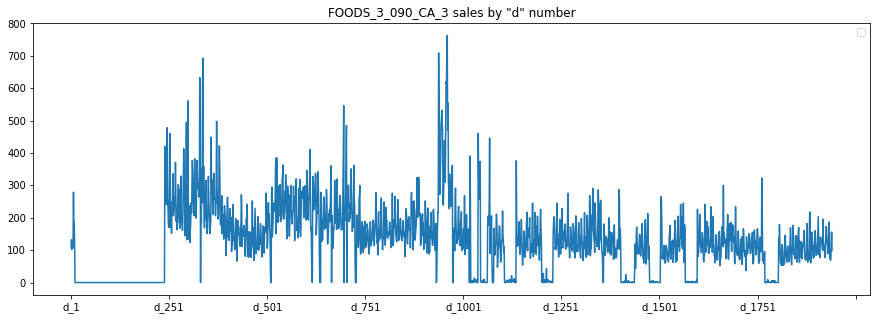

In [6]:


# Below we are chaining the following steps in pandas:
# 1. Select the item.
# 2. Set the id as the index, Keep only sales data columns
# 3. Transform so it's a column
# 4. Plot the data
sales.loc[sales['id'] == 'FOODS_3_090_CA_3_evaluation'] \
    .set_index('id')[d_cols] \
    .T \
    .plot(figsize=(15, 5),
          title='FOODS_3_090_CA_3 sales by "d" number')
plt.legend('')
plt.show()

In [ ]:
twenty_examples = stv.sample(20, random_state=529) \
        .set_index('id')[d_cols] \
    .T \
    .merge(cal.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

fig, axs = plt.subplots(10, 2, figsize=(15, 20))
axs = axs.flatten()
ax_idx = 0
for item in twenty_examples.columns:
    twenty_examples[item].plot(title=item,
                              ax=axs[ax_idx])
    ax_idx += 1
plt.tight_layout()
plt.show()

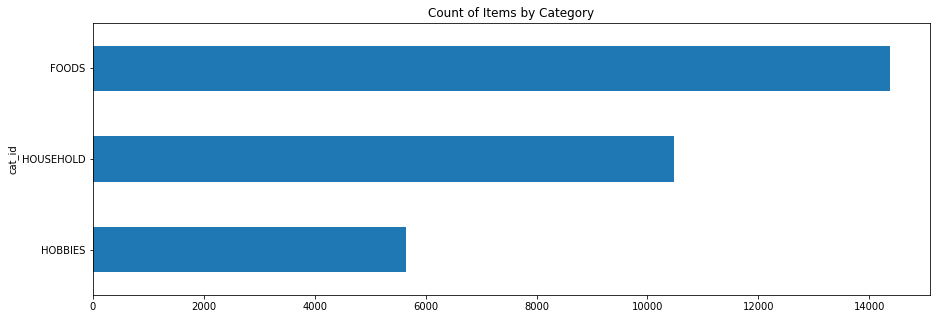

In [60]:
stv.groupby('cat_id').count()['id'] \
    .sort_values() \
    .plot(kind='barh', figsize=(15, 5), title='Count of Items by Category')
plt.show()

In [125]:
stv[4000:4100]

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
4000,HOUSEHOLD_1_396_CA_2_validation,HOUSEHOLD_1_396,HOUSEHOLD_1,HOUSEHOLD,CA_2,CA,0,0,0,0,...,1,0,2,1,0,0,0,0,0,2
4001,HOUSEHOLD_1_397_CA_2_validation,HOUSEHOLD_1_397,HOUSEHOLD_1,HOUSEHOLD,CA_2,CA,5,1,2,2,...,2,2,2,0,1,3,1,0,1,2
4002,HOUSEHOLD_1_398_CA_2_validation,HOUSEHOLD_1_398,HOUSEHOLD_1,HOUSEHOLD,CA_2,CA,0,0,0,0,...,0,2,3,2,0,1,1,3,4,2
4003,HOUSEHOLD_1_399_CA_2_validation,HOUSEHOLD_1_399,HOUSEHOLD_1,HOUSEHOLD,CA_2,CA,0,0,0,0,...,6,7,7,5,7,3,5,8,6,10
4004,HOUSEHOLD_1_400_CA_2_validation,HOUSEHOLD_1_400,HOUSEHOLD_1,HOUSEHOLD,CA_2,CA,0,0,0,0,...,2,2,0,0,0,3,3,0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4095,HOUSEHOLD_1_491_CA_2_validation,HOUSEHOLD_1_491,HOUSEHOLD_1,HOUSEHOLD,CA_2,CA,0,0,0,0,...,0,0,1,0,0,0,0,1,0,2
4096,HOUSEHOLD_1_492_CA_2_validation,HOUSEHOLD_1_492,HOUSEHOLD_1,HOUSEHOLD,CA_2,CA,0,4,1,0,...,1,1,3,0,1,2,0,2,2,2
4097,HOUSEHOLD_1_493_CA_2_validation,HOUSEHOLD_1_493,HOUSEHOLD_1,HOUSEHOLD,CA_2,CA,1,1,0,1,...,0,0,1,0,0,1,1,1,1,0
4098,HOUSEHOLD_1_494_CA_2_validation,HOUSEHOLD_1_494,HOUSEHOLD_1,HOUSEHOLD,CA_2,CA,0,0,0,0,...,3,2,6,2,0,0,2,1,6,5


In [53]:
past_sales = stv.set_index('id')[d_cols] \
    .T \
    .merge(cal.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

In [57]:
items_col = [c for c in past_sales.columns if 'HOBBIES' in c]

In [67]:
hobbies = past_sales[items_col].sum(axis=1)
hobbies[hobbies==0]

date
2011-12-25    0
2012-12-25    0
2013-12-25    0
2014-12-25    0
2015-12-25    0
dtype: int64

## Merging the data with real dates
- We are given a calendar with additional information about past and future dates.
- The calendar data can be merged with our days data
- From this we can find weekly and annual trends

In [106]:


# day_from_date('2011-01-29', cal)
# d_from_date('2011-01-31', cal)
day_from_date(date_from_d('d_1', cal), cal)

'Saturday'

In [101]:
len(cal[cal['date']=='2011-01-32'])

0

In [4]:
stv.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


Text(0.5, 1.0, 'HOBBIES category at CA_1')

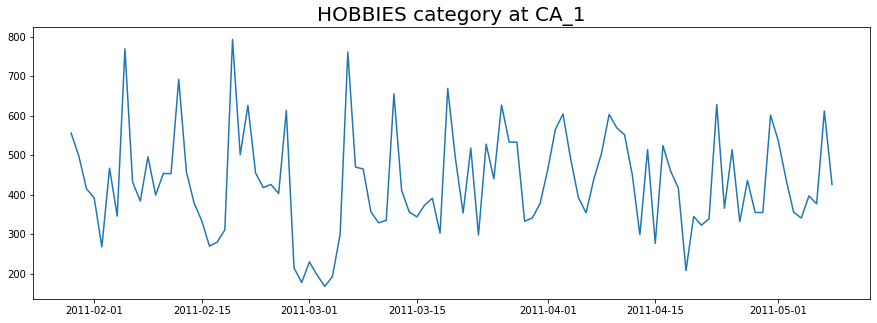

In [57]:
dates = example.date

store_id = 'CA_1'
cat_id = 'HOBBIES'
plt.figure(0, figsize=(15,5))
plt.plot(dates[:100], sales[(sales['store_id']==store_id) & (sales['cat_id']==cat_id)][d_cols].sum(axis=0)[:100])
plt.title('{} category at {}'.format(cat_id, store_id), fontsize=20)

In [6]:
cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


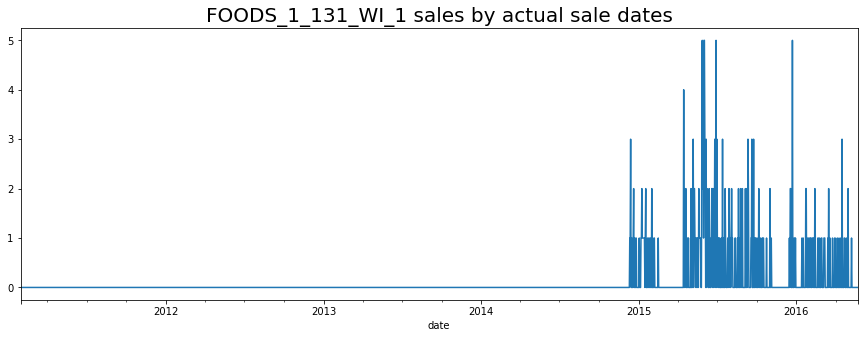

In [36]:
# def merge_with_calendar(stv, cal, item_id, d_cols):
#     example = stv.loc[stv['id'] == item_id][d_cols].T
    
#     col_name = example.columns.item()
#     if item_id.split('_')[-1] == 'validation' or item_id.split('_')[-1] == 'evaluation':
#         item_id = '_'.join(item_id.split('_')[:-1])
#     example = example.rename(columns={col_name:item_id}) # Name it correctly
#     example = example.reset_index().rename(columns={'index': 'd'}) # make the index "d"
#     example = example.merge(cal, how='left', validate='1:1')
    
#     return example

full_id = 'FOODS_1_131_WI_1'



example = merge_with_calendar(sales, cal, full_id, d_cols)

fig, ax = plt.subplots(figsize=(20,4))
example.set_index('date')[full_id] \
    .plot(figsize=(15, 5), ax=ax)

ax.set_title(full_id + ' sales by actual sale dates', fontsize=20)
plt.show()


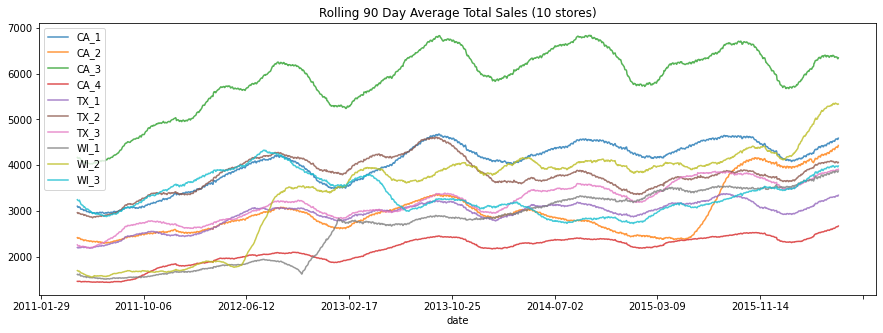

In [56]:
past_sales = sales.set_index('id')[d_cols] \
    .T \
    .merge(cal.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

store_list = sellp['store_id'].unique()
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(90).mean() \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Rolling 90 Day Average Total Sales (10 stores)')
plt.legend(store_list)
plt.show()